In [1]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

if not (os.path.isdir(hp.mels_dir)):
    os.mkdir(hp.mels_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mels_dir, hp.mels_dir))
    
if not (os.path.isdir(hp.mags_dir)):
    os.mkdir(hp.mags_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mags_dir, hp.mags_dir))

In [3]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [216]:
fnames, texts, secs, text_lengths = [], [], [], []

for line in tqdm(lines):
    line = j2hcj(line)
    _, _, text, _ = line.strip().split('|')
    text_lengths.append(len(text))

100%|█████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 11758.56it/s]


In [217]:
maxlen, minLen = max(text_lengths), min(text_lengths)

In [218]:
maxlen = max(text_lengths)

char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    
    padLen = maxlen - len(text)
    
    text = text + ' ' * padLen
    
    encodedText = [char2idx[char] for char in text]
    
    encodedText = np.array(encodedText, np.int32).tostring()
    
    fnames.append(fname); 
    texts.append(encodedText)
    secs.append(float(sec)); 

100%|██████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 9997.96it/s]


In [219]:
y = list(map(lambda x: len(x), texts))

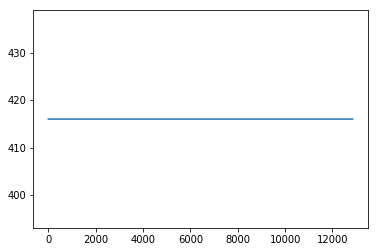

In [220]:
plt.plot(y)

In [221]:
fnames_tensor = tf.convert_to_tensor(fnames)
texts_tensor = tf.convert_to_tensor(texts)
lengths_tensor = tf.convert_to_tensor(text_lengths)

In [222]:
fnames_tensor

<tf.Tensor 'Const_15:0' shape=(12853,) dtype=string>

In [223]:
texts_tensor

<tf.Tensor 'Const_16:0' shape=(12853,) dtype=string>

In [224]:
# fnames_placeholder = tf.placeholder(fnames_tensor.dtype, [None, ])
# texts_placeholder = tf.placeholder(texts_tensor.dtype, [None, ])
# lengths_placeholder = tf.placeholder(lengths_tensor.dtype, [None,])

In [226]:
num_epochs = 1
dataset = tf.data.Dataset.from_tensor_slices(tuple([fnames_tensor, texts_tensor, lengths_tensor])).shuffle(fnames_tensor.shape[0]).repeat(num_epochs)

In [205]:
# num_epochs = 1
# dataset = tf.data.Dataset.from_tensor_slices((fnames_placeholder, texts_placeholder, lengths_placeholder)).shuffle(fnames_tensor.shape[0]).repeat(num_epochs)

In [271]:
def dataset_length_fn(fname, text, text_length, c): #(uttids, tgt_ids, tgt_labels, tgt_paddings, frames, src_paddings):
#     print(fname)
#     print(text)
#     print(text_length)
    return c

In [207]:
# dataset.output_shapes

(TensorShape([]), TensorShape([]), TensorShape([]))

In [208]:
# dataset = dataset.apply(
#                         tf.data.experimental.bucket_by_sequence_length(
#                         element_length_func=dataset_length_fn,
#                         bucket_batch_sizes= [32, 32, 32, 32, 32, 32, 32, 32],
#                         bucket_boundaries=[10, 20, 30, 40, 50, 60, 70],
#                         pad_to_bucket_boundary = [False, True, False],
#        ))

Tensor("arg0:0", shape=(), dtype=string)
Tensor("arg1:0", shape=(), dtype=string)
Tensor("arg2:0", shape=(), dtype=int32)


In [227]:
iterator = dataset.make_one_shot_iterator()
file_name, text, length = iterator.get_next()
decoded_text = tf.decode_raw(text, tf.int32)

In [229]:
with tf.Session() as sess:    
    for i in range(3):
        a = sess.run(decoded_text)
        print(a)

# with tf.Session() as sess:    
#     for i in range(3):
#         a = sess.run(decoded_text, feed_dict={fnames_placeholder: fnames, 
#                                               texts_placeholder: texts, 
#                                               lengths_placeholder: text_lengths
#                                           })
#         print(a)

[ 7 40  4  7 33  4 28  0  9 21 16 24  4  8 40  4 38  4  0  8 24 13  8 24
 18  8 24  8 32 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[ 7 33 13 38  0  5 20  7  8 40  0  8 24 16 21 54  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[ 8 20  8 40  3 38  4  8 38  2  0  8 33  2  3 28  8  9 20  8  8 25  7 24
  0  2 28  4  1 28  0  8 40 18  8 38  4  0  1 24  8 22 52  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [273]:
def spectrogram_wrap_up_(fname, length):
    
    fname = fname.decode()
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
    #     if os.path.isfile(mel_path) and os.path.isfile(mag_path):
    if False:

        mag = np.load(mag_path)
        mel = np.load(mel_path) 

    else :

        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag_coef = np.mean(spectrogram(wav, nsc, nov, fs), axis=0)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        mag = true_spectrogram(wav, nsc, nov)

        active = np.where(mag_coef > hp.db_limit)[0]

        first = active[0]
        last = active[-1] + 1

        if first - hp.offset >= 0:
            first = first - hp.offset
        else:
                first = 0

        if last + hp.offset < len(mag_coef):
            last = last + hp.offset
        else:
            last = len(mag_coef)

        mag = mag[:, first:last]
        mel = mel[:, first:last]

        mag = mag / hp.max_db
        mel = mel / hp.max_db

        # Do I really need 
        t = mel.shape[1]
        num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # 0 for multiples

        mel = np.pad(mel.T, [[0, num_paddings], [0, 0]], mode="minimum")
        mag = np.pad(mag.T, [[0, num_paddings], [0, 0]], mode="minimum")

        mel = mel.T
        mag = mag.T

        mel = mel.astype(np.float32)
        mag = mag.astype(np.float32) # Default is float64, type crashes at the Attention Wrapper

        print('{:d}:{:d}'.format(first, last))

        np.save(mag_path, mag)
        np.save(mel_path, mel)

#     print(fname)
#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mag, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 2)
#     plt.imshow(mel, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 3)
#     plt.plot(mag_coef)
#     plt.show()

    y = mel.T.reshape((-1, hp.n_mels*hp.r))
    mel = (mel.T[hp.r - 1::hp.r, :]) # Reduce sample size by r
    mag = mag.T
    
    return y, mel, mag, length

In [275]:
dataset = dataset.map(
    lambda fname, text, lengths, c: tf.py_func(spectrogram_wrap_up_,
                                [fname, lengths],
                                [tf.float32, tf.float32, tf.float32, tf.int32]))

In [276]:
dataset

<MapDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float32, tf.float32, tf.float32, tf.int32)>

In [268]:
batch_size = 32
batch_dataset = dataset.batch(batch_size)

In [270]:
dataset = dataset.apply(
                        tf.data.experimental.bucket_by_sequence_length(
                        element_length_func=dataset_length_fn,
                        bucket_batch_sizes= [32, 32, 32, 32, 32, 32, 32, 32],
                        bucket_boundaries=[10, 20, 30, 40, 50, 60, 70],
#                         pad_to_bucket_boundary = [False, True, False]
                        ))

Tensor("arg0:0", dtype=float32)
Tensor("arg1:0", dtype=float32)
Tensor("arg2:0", dtype=float32)


ValueError: Cannot iterate over a shape with unknown rank.

In [248]:
iterator = batch_dataset.make_one_shot_iterator()
y, mel, mag = iterator.get_next()

In [249]:
with tf.Session() as sess:    
    for i in range(3):
        y_, mel_, mag_ = sess.run([y, mel, mag])
#       print(mel_)
        plt.subplot(1, 2, 1)
        plt.imshow(mel_.T, origin='lower')
        plt.subplot(1, 2, 2)
        plt.imshow(mag_.T, origin='lower')
        plt.show()

9:43
11:39
14:83
15:56
7:57
9:49
11:70
8:64
11:42
8:99
22:79
15:70
12:59
13:80
11:44
21:113
18:76
14:85
14:90
0:48
11:56
16:70
4:52
18:64
2:51
12:61
2:49
17:100
17:75
17:77
20:61
16:66


InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [7,400] and element 1 had shape [6,400].
	 [[node IteratorGetNext_22 (defined at <ipython-input-248-c0f0f6c7f89b>:2)  = IteratorGetNext[output_shapes=[<unknown>, <unknown>, <unknown>], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_22)]]

Caused by op 'IteratorGetNext_22', defined at:
  File "c:\users\주환\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-248-c0f0f6c7f89b>", line 2, in <module>
    y, mel, mag = iterator.get_next()
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 421, in get_next
    name=name)), self._output_types,
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 2108, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3274, in create_op
    op_def=op_def)
  File "c:\users\주환\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot batch tensors with different shapes in component 0. First element had shape [7,400] and element 1 had shape [6,400].
	 [[node IteratorGetNext_22 (defined at <ipython-input-248-c0f0f6c7f89b>:2)  = IteratorGetNext[output_shapes=[<unknown>, <unknown>, <unknown>], output_types=[DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_22)]]


In [236]:
y, mel, mag = tf.py_func(spectrogram_wrap_up_, [dataset], [tf.float32, tf.float32, tf.float32])

TypeError: Expected list for 'input' argument to 'PyFunc' Op, not <RepeatDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.int32)>.

In [214]:
with tf.Session() as sess:    
    for i in range(30):
        a, b, c = sess.run([file_name, text, length], feed_dict={fnames_placeholder: fnames, 
                                              texts_placeholder: texts, 
                                              lengths_placeholder: text_lengths
                                                                })
        print(a)
        print(b)
        print(c)

b'4/4_4155.wav'
b'\x08\x00\x00\x00\x1c\x00\x00\x00\r\x00\x00\x00\x19\x00\x00\x00\x04\x00\x00\x00\x14\x00\x00\x00\x08\x00\x00\x00\x1d\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00%\x00\x00\x00\t\x00\x00\x00(\x00\x00\x00\x0b\x00\x00\x00\x18\x00\x00\x00\x04\x00\x00\x00\x08\x00\x00\x00\'\x00\x00\x00\x00\x00\x00\x00\n\x00\x00\x00\x14\x00\x00\x00\x08\x00\x00\x00(\x00\x00\x00\x01\x00\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00"\x00\x00\x00\x08\x00\x00\x00\x16\x00\x00\x006\x00\x00\x00'
31
b'3/3_4584.wav'
b'\x01\x00\x00\x00&\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x14\x00\x00\x00\x04\x00\x00\x00\x14\x00\x00\x00\x05\x00\x00\x00\x0e\x00\x00\x00\x14\x00\x00\x00\x01\x00\x00\x00\x1c\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x15\x00\x00\x00\x0e\x00\x00\x00\x1d\x00\x00\x00\x04\x00\x00\x00&\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00\x14\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00\x14\x00\x00\x00\x02\x00\x00\x00&\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x0

b'\x06\x00\x00\x00\x14\x00\x00\x00\x05\x00\x00\x00\x08\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00(\x00\x00\x00\r\x00\x00\x00\x08\x00\x00\x00\x18\x00\x00\x00\x12\x00\x00\x00\x02\x00\x00\x00&\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00\x19\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00!\x00\x00\x00\x07\x00\x00\x00&\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00(\x00\x00\x00\x04\x00\x00\x00\x04\x00\x00\x00\x1c\x00\x00\x00\x00\x00\x00\x00\n\x00\x00\x00\x14\x00\x00\x00\t\x00\x00\x00\x08\x00\x00\x00\x14\x00\x00\x00\x08\x00\x00\x00\x1d\x00\x00\x00\x12\x00\x00\x00\x08\x00\x00\x00\x18\x00\x00\x006\x00\x00\x00'
41
b'4/4_1639.wav'
b'\x08\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x1c\x00\x00\x00\x08\x00\x00\x00\t\x00\x00\x00\x14\x00\x00\x00\x08\x00\x00\x00\x08\x00\x00\x00\x19\x00\x00\x00\x02\x00\x00\x00&\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x1f\x00\x00\x00\x01\x00\x00\x00!\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00(\x00\x00\x00\x02\x00

b'\t\x00\x00\x00\x18\x00\x00\x00\x02\x00\x00\x00&\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00\x14\x00\x00\x00\x04\x00\x00\x00!\x00\x00\x00\x08\x00\x00\x00\x19\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00!\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x18\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x16\x00\x00\x00\x08\x00\x00\x00"\x00\x00\x00\x04\x00\x00\x00&\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00\x15\x00\x00\x00\x08\x00\x00\x00 \x00\x00\x004\x00\x00\x00'
33
b'3/3_4235.wav'
b'\t\x00\x00\x00(\x00\x00\x00\x02\x00\x00\x00\x14\x00\x00\x00\x02\x00\x00\x00\t\x00\x00\x00!\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00(\x00\x00\x00\x08\x00\x00\x00$\x00\x00\x00\x01\x00\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00(\x00\x00\x00\t\x00\x00\x00\x14\x00\x00\x00\x01\x00\x00\x00\x03\x00\x00\x00\x1f\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00(\x00\x00\x00\x04\x00\x00\x00\x15\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x18\x00\x00\x

In [ ]:
batch_size = 32
batch_dataset = dataset.batch(batch_size)

In [ ]:
batch_dataset

In [ ]:
iterator = dataset.make_one_shot_iterator()`
file_name, text = iterator.get_next()
text_decoded = tf.decode_raw(text, tf.int32)

In [ ]:
y, mel, mag = tf.py_func(spectrogram_wrap_up, [fname], [tf.float32, tf.float32, tf.float32])

In [ ]:
tf.data.experimental.bucket_by_sequence_length

In [ ]:
tf.data.experimental.bucket_by_sequence_length(
    element_length_func,
    bucket_boundaries,
    bucket_batch_sizes,
    padded_shapes=None,
    pad_to_bucket_boundary=False,
    no_padding=False
)

In [ ]:
# iterator = dataset.make_one_shot_iterator()
# file_name, text = iterator.get_next()
# text_decoded = tf.decode_raw(text, tf.int32)

iterator = batch_dataset.make_one_shot_iterator()
file_name, text = iterator.get_next()
text_decoded = tf.decode_raw(text, tf.int32)

In [ ]:
with tf.Session() as sess:    
    for i in range(3):
        f, t = sess.run([file_name, text])
        print(f)
        print(t)

In [ ]:
with tf.Session() as sess:    
    for i in range(3):
        f, t = sess.run([file_name, text_decoded])
        print(f)
        print(t)

In [240]:
def spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def mel_spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0, n_mels = hp.n_mels)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def true_spectrogram(wav, nsc, nov):
    
    
    S = librosa.core.stft(wav, n_fft=nsc, hop_length=nov)
    Sxx = abs(S)
    dbS = 20 * np.log10(np.maximum(Sxx, hp.eps))
    
    
    return dbS

In [243]:
def learning_rate_decay(init_lr, global_step, warmup_steps=4000.):
    '''Noam scheme from tensor2tensor'''
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

In [ ]:
fname = file_name
text = text_decoded

In [241]:
def spectrogram_wrap_up(fname):
    
    fname = fname.decode()
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
    #     if os.path.isfile(mel_path) and os.path.isfile(mag_path):
    if False:

        mag = np.load(mag_path)
        mel = np.load(mel_path) 

    else :

        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag_coef = np.mean(spectrogram(wav, nsc, nov, fs), axis=0)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        mag = true_spectrogram(wav, nsc, nov)

        active = np.where(mag_coef > hp.db_limit)[0]

        first = active[0]
        last = active[-1] + 1

        if first - hp.offset >= 0:
            first = first - hp.offset
        else:
                first = 0

        if last + hp.offset < len(mag_coef):
            last = last + hp.offset
        else:
            last = len(mag_coef)

        mag = mag[:, first:last]
        mel = mel[:, first:last]

        mag = mag / hp.max_db
        mel = mel / hp.max_db

        # Do I really need 
        t = mel.shape[1]
        num_paddings = hp.r - (t % hp.r) if t % hp.r != 0 else 0 # 0 for multiples

        mel = np.pad(mel.T, [[0, num_paddings], [0, 0]], mode="minimum")
        mag = np.pad(mag.T, [[0, num_paddings], [0, 0]], mode="minimum")

        mel = mel.T
        mag = mag.T

        mel = mel.astype(np.float32)
        mag = mag.astype(np.float32) # Default is float64, type crashes at the Attention Wrapper

        print('{:d}:{:d}'.format(first, last))

        np.save(mag_path, mag)
        np.save(mel_path, mel)

#     print(fname)
#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(mag, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 2)
#     plt.imshow(mel, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 3, 3)
#     plt.plot(mag_coef)
#     plt.show()

    y = mel.T.reshape((-1, hp.n_mels*hp.r))
    mel = (mel.T[hp.r - 1::hp.r, :]) # Reduce sample size by r
    mag = mag.T
    
    return y, mel, mag

In [242]:
def spectrogram_wrap_up_2(names):
    
    y = []
    mel = []
    mag = []
    
    for name in names:
#       print(name)
        y_, mel_, mag_ = spectrogram_wrap_up(name)
        y.append(y_)
        mel.append(mel_)
        mag.append(mag_)
        
    y = np.asarray(y)
    mel = np.asarray(mel)
    mag = np.asarray(mag)
    
    return y, mel, mag

In [ ]:
# y, mel, mag = tf.py_func(spectrogram_wrap_up, [fname], [tf.float32, tf.float32, tf.float32])
y, mel, mag = tf.py_func(spectrogram_wrap_up_2, [fname], [tf.float32, tf.float32, tf.float32])

In [ ]:
with tf.Session() as sess:    
    for i in range(3):
        f = sess.run([fname])
        print(f[0][0].decode())

In [ ]:
with tf.Session() as sess:    
    for i in range(3):
        y_, mel_, mag_ = sess.run([y, mel, mag])
        print(mel_)
        plt.subplot(1, 2, 1)
        plt.imshow(mel_[0].T, origin='lower')
        plt.subplot(1, 2, 2)
        plt.imshow(mag_[0].T, origin='lower')
        plt.show()

In [ ]:
decoder_input = tf.concat((tf.zeros_like(mel[:1, :]), mel[:-1, :]), 0)

In [ ]:
decoder_input.set_shape([None, hp.n_mels])

In [ ]:
decoder_input

In [ ]:
with tf.variable_scope("embedding", reuse=tf.AUTO_REUSE):
    lookup_table = tf.get_variable('lookup_table', 
                                   dtype=tf.float32, 
                                   shape=[len(hp.vocab), hp.embed_size],
                                   initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))
    

In [ ]:
embed_text = tf.nn.embedding_lookup(lookup_table, text_decoded)
embed_text = tf.expand_dims(embed_text, 0)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(embed_text)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("prenet", reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(embed_text, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
    outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 

    prenet_result = outputs

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(prenet_result)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
    for k in range(1, hp.K + 1):
        with tf.variable_scope("filter_num_{}".format(k)):
            params = {"inputs":prenet_result, "filters":hp.num_k_filter, "kernel_size":k,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}

            # Works when resue = True
            # For i loop, filter is reused.

            conv_outputs = tf.layers.conv1d(**params)
            if k == 1:
                conv_bank_outputs = conv_outputs
            else:
                conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

    conv_bank_result = conv_bank_outputs

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_bank_result)
    plt.imshow(x[0, :, :], aspect='auto')

In [ ]:
 max_pooling_result = tf.layers.max_pooling1d(conv_bank_result, pool_size=2, strides=1, padding="same")

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(max_pooling_result)
    plt.imshow(x[0, :, :], aspect='auto')

In [ ]:
conv_bank_result.shape

In [ ]:
with tf.variable_scope("conv1d_1"):       
    params = {"inputs":max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}
    conv_proj_1_result = tf.layers.conv1d(**params)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_proj_1_result)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("conv1d_1"):
    bn_1_result = tf.contrib.layers.batch_norm(inputs=conv_proj_1_result,
                                           center=True,
                                           scale=True,
                                           updates_collections=None,
                                           is_training=True,
                                           scope="conv1d_1",
                                           fused=True,
                                           reuse=tf.AUTO_REUSE)
    batch_norm_1_result = tf.nn.relu(bn_1_result)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(batch_norm_1_result)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("conv1d_2"):
    params = {"inputs":batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                    "dilation_rate":1, "padding":"SAME", "activation":None, 
                    "use_bias":False, "reuse":tf.AUTO_REUSE}
    conv_proj_2_result = tf.layers.conv1d(**params)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(conv_proj_2_result)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("conv1d_2"):
    bn_2_result = tf.contrib.layers.batch_norm(inputs=conv_proj_2_result,
                                           center=True,
                                           scale=True,
                                           updates_collections=None,
                                           is_training=True,
                                           scope="conv1d_2",
                                           fused=True,
                                           reuse=tf.AUTO_REUSE)
    batch_norm_2_result = tf.nn.relu(bn_2_result)


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(batch_norm_2_result)
    plt.imshow(x[0, :, :])

In [ ]:
res_output = prenet_result + batch_norm_2_result

In [ ]:
res_output

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(res_output)
    plt.imshow(x[0, :, :])

In [ ]:
highwaynet_output = []

for i in range(hp.num_highwaynet_blocks):
    scope = "highwaynet_{:d}".format(i)
    with tf.variable_scope(scope):
        
        if i == 0:
            highwaynet_input = res_output
        else:
            highwaynet_input = highwaynet_output

        H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
        T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                            bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
        highwaynet_output = H*T + highwaynet_input*(1.-T)    

In [ ]:
highwaynet_output

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(highwaynet_output)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("gru", reuse=tf.AUTO_REUSE):
#     cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
#     cell_bw = tf.contrib.rnn.GRUCell(hp.num_gru_units)
    cell = tf.contrib.rnn.GRUCell(128)
    cell_bw = tf.contrib.rnn.GRUCell(128)

    output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
    gru_result = tf.concat(output, 2)   

In [ ]:
gru_result

In [ ]:
decoder_input

In [ ]:
with tf.variable_scope("decoder_prenet", reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(decoder_input, units=hp.num_prenet_node_1, activation=tf.nn.relu, name="dense1")
    outputs = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout1")
    outputs = tf.layers.dense(outputs, units=hp.num_prenet_node_2, activation=tf.nn.relu, name="dense2")
    decoder_prenet_result = tf.layers.dropout(outputs, rate=hp.dropout_rate, name="dropout2") 

In [ ]:
decoder_prenet_result

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(decoder_prenet_result)
    plt.imshow(x)

In [ ]:
decoder_prenet_result

In [ ]:
gru_result

In [ ]:
decoder_prenet_result_4D

In [ ]:
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    decoder_prenet_result_4D = tf.expand_dims(decoder_prenet_result, 0)

    attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(hp.num_attention_units, gru_result)
    decoder_cell = tf.contrib.rnn.GRUCell(hp.num_gru_units)
    cell_with_attention = tf.contrib.seq2seq.AttentionWrapper(decoder_cell,
                                                              attention_mechanism,
                                                              hp.num_attention_units,
                                                              alignment_history=True)
    dec, state = tf.nn.dynamic_rnn(cell_with_attention, decoder_prenet_result_4D, dtype=tf.float32)
#     dec, state = keras.layers.RNN(cell_with_attention, decoder_prenet_result_4D, dtype=tf.float32)

In [ ]:
decoder_prenet_result_4D

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(state)
    x

In [ ]:
x.shape

In [ ]:
with tf.variable_scope("attention_decoder", reuse=tf.AUTO_REUSE):
    
    alignment = tf.transpose(state.alignment_history.stack(),[1,2,0])

    with tf.variable_scope("decoder_gru_1", reuse=tf.AUTO_REUSE):
        cell = tf.contrib.rnn.GRUCell(128)
        output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
        gru_output_1 = tf.concat(output, 2)

    dec = dec + gru_output_1

    with tf.variable_scope("decoder_gru_2", reuse=tf.AUTO_REUSE):
        cell = tf.contrib.rnn.GRUCell(128)
        output, _ = tf.nn.dynamic_rnn(cell, dec, dtype=tf.float32)
        gru_output_2 = tf.concat(output, 2)

    dec = dec + gru_output_2

    # Outputs => (N, T_y/r, n_mels*r)
    y_hat = tf.layers.dense(dec, hp.n_mels*hp.r)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(y_hat)
    plt.imshow(x[0, :, :])

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_input = tf.reshape(y_hat, [1, -1, hp.n_mels])

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_banks", reuse=tf.AUTO_REUSE):
        for k in range(1, hp.K + 1):
            with tf.variable_scope("filter_num_{}".format(k)):
                params = {"inputs":dec_2_input, "filters":hp.num_k_filter, "kernel_size":k,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

                # Works when resue = True
                # For i loop, filter is reused.

                conv_outputs = tf.layers.conv1d(**params)
                if k == 1:
                    conv_bank_outputs = conv_outputs
                else:
                    conv_bank_outputs = tf.concat((conv_bank_outputs, conv_outputs), axis=2)

    dec_2_conv_bank_result = conv_bank_outputs


In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_max_pooling_result = tf.layers.max_pooling1d(dec_2_conv_bank_result, pool_size=2, strides=1, padding="same")

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        params = {"inputs":dec_2_max_pooling_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        dec_2_conv_proj_1_result = tf.layers.conv1d(**params)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_1"):
        bn_1_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_1_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_1",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        dec_2_batch_norm_1_result = tf.nn.relu(bn_1_result)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        params = {"inputs":dec_2_batch_norm_1_result, "filters":hp.num_conv1d_proj_filter, "kernel_size":hp.size_conv1d_proj_filter,
                        "dilation_rate":1, "padding":"SAME", "activation":None, 
                        "use_bias":False, "reuse":tf.AUTO_REUSE}

        dec_2_conv_proj_2_result = tf.layers.conv1d(**params)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("conv1d_2"):
        bn_2_result = tf.contrib.layers.batch_norm(inputs=dec_2_conv_proj_2_result,
                                               center=True,
                                               scale=True,
                                               updates_collections=None,
                                               is_training=True,
                                               scope="conv1d_2",
                                               fused=True,
                                               reuse=tf.AUTO_REUSE)
        dec_2_batch_norm_2_result = tf.nn.relu(bn_2_result)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    dec_2_sync_result = tf.layers.dense(dec_2_batch_norm_2_result, 128)

In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    for i in range(hp.num_highwaynet_blocks):
        scope = "highwaynet_{:d}".format(i)
        with tf.variable_scope(scope):

            if i == 0:
                highwaynet_input = dec_2_sync_result
            else:
                highwaynet_input = highwaynet_output

            highwaynet_output = []

            H = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.relu, name="dense1", reuse=tf.AUTO_REUSE)
            T = tf.layers.dense(highwaynet_input, units=hp.num_highwaynet_units, activation=tf.nn.sigmoid,
                                bias_initializer=tf.constant_initializer(-1.0), name="dense2", reuse=tf.AUTO_REUSE)
            highwaynet_output = H*T + highwaynet_input*(1.-T)

In [ ]:
with tf.variable_scope("dec_2_gru", reuse=tf.AUTO_REUSE):
    cell = tf.contrib.rnn.GRUCell(128)
    cell_bw = tf.contrib.rnn.GRUCell(128)

    output, _ = tf.nn.bidirectional_dynamic_rnn(cell, cell_bw, highwaynet_output, dtype=tf.float32)
    dec_2_gru_result = tf.concat(output, 2)


In [ ]:
with tf.variable_scope("decoder2", reuse=tf.AUTO_REUSE):
    with tf.variable_scope("final", reuse=tf.AUTO_REUSE):
        z_hat = tf.layers.dense(dec_2_gru_result, 1 + hp.nsc_sec*hp.fs//2)

In [ ]:
z_hat

In [ ]:
mag[0].shape

In [ ]:
loss1 = tf.reduce_mean(tf.abs(y_hat - y))
loss2 = tf.reduce_mean(tf.abs(z_hat - mag))
loss = loss1 + loss2

In [ ]:
loss

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = sess.run(loss)
    print(x)

In [ ]:
global_step = tf.Variable(0, name='global_step', trainable=False)
lr = learning_rate_decay(hp.lr, global_step=global_step)
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr)

## gradient clipping
gvs = optimizer.compute_gradients(loss)

In [ ]:
clipped = []

for grad, var in gvs:
    if grad is None:
        clipped.append((grad, var))
    else :
        grad = tf.clip_by_norm(grad, 5.)
        clipped.append((grad, var))
    
train_op = optimizer.apply_gradients(clipped, global_step=global_step)

In [ ]:
mode = 'train'

tf.summary.scalar('{}/loss1'.format(mode), loss1)
tf.summary.scalar('{}/loss'.format(mode), loss)
tf.summary.scalar('{}/lr'.format(mode), hp.lr)

tf.summary.image("{}/mel_gt".format(mode), tf.expand_dims(y, -1), max_outputs=1)
tf.summary.image("{}/mel_hat".format(mode), tf.expand_dims(y_hat, -1), max_outputs=1)
tf.summary.image("{}/mag_gt".format(mode), tf.expand_dims(mag, -1), max_outputs=1)
tf.summary.image("{}/mag_hat".format(mode), tf.expand_dims(z_hat, -1), max_outputs=1)

merged = tf.summary.merge_all()

In [ ]:
with tf.Session() as sess:
    for i in range(100):
        sess.run(tf.global_variables_initializer())
        _, gs = sess.run([train_op, global_step])
        print(gs)

In [ ]:
hp.logdir = '.'

In [ ]:
with tf.train.MonitoredTrainingSession(summary_dir=hp.logdir, save_summaries_secs=60) as sess:
    while 1:
        for _ in tqdm(range(100), total=100, ncols=70, leave=False, unit='b'):
            #_, gs = sess.run([train_op, global_step])
            
            _, gs = sess.run([dec_2_sync_result])

            # Write checkpoint files
            if gs % 1000 == 0:
                sv.saver.save(sess, hp.logdir + '/model_gs_{}k'.format(gs//1000))

                # plot the first alignment for logging
                al = sess.run(alignment)
                plt.imshow(al[0])
                ply.show()